In [1]:
import json

import numpy as np
from matplotlib import pyplot as plt

from capacityutil import signal_analysis

with open("../1132307.json", "r") as f:
    data = json.load(f)

In [2]:
unsynced, synced, has_sync, off, corr = signal_analysis.decode_apt_image(
    ogg_file=data["file"],
    dest_path="cache.out",
    force=False,
)
len(synced)

1911

In [3]:
snrs = signal_analysis.determine_snrs(
    ogg_file=data["file"],
    dest_path="cache.out",
)
len(snrs)

956

0.01157966005268885 0.002834661037403416 0.006551237687302827


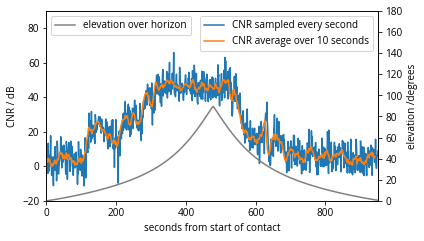

In [7]:
import matplotlib

matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams["font.family"] = "Open Sans"

# https://stackoverflow.com/a/14314054
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(snrs, label="CNR sampled every second")
ax1.plot(moving_average(snrs, 10), label="CNR average over 10 seconds")
ax1.set_xlabel("seconds from start of contact")
ax1.set_ylim(-20, 90)
ax1.set_xlim(0, len(snrs))
ax1.set_ylabel("CNR / dB")
ax1.legend()

import ephem
import datetime
import math

gsobj = ephem.Observer()
gsobj.lat = str(data["station_lat"])
gsobj.lon = str(data["station_lng"])
gsobj.elevation = data["station_alt"]
satobj = ephem.readtle(data["satellite_info"]["name"], *data["tle"])

def _elev(satobj, gsobj, ts):
    gsobj.date = datetime.datetime.utcfromtimestamp(ts)
    satobj.compute(gsobj)
    return satobj.alt / math.pi * 180.

def _delay(satobj, gsobj, ts):
    gsobj.date = datetime.datetime.utcfromtimestamp(ts)
    satobj.compute(gsobj)
    return satobj.range / 299792458

timestamps = np.arange(data["start_unix"], data["end_unix"], 1)
elevs = [_elev(satobj, gsobj, ts) for ts in timestamps]

delays = [_delay(satobj, gsobj, ts) for ts in timestamps]
print(max(delays), min(delays), np.mean(delays))

ax2.plot(elevs, color="gray", label="elevation over horizon")
ax2.set_ylabel("elevation /degrees")
ax2.set_ylim(0, 180)
#ax2.set_yticks(list(range(0, 91, 10)))
ax2.legend(loc="upper left")

fig.set_size_inches(6, 3.45)
plt.tight_layout()
plt.savefig("cache.out/1132307_cnr.pdf")
plt.show()

0.01157966005268885 0.002834661037403416 0.006551237687302827


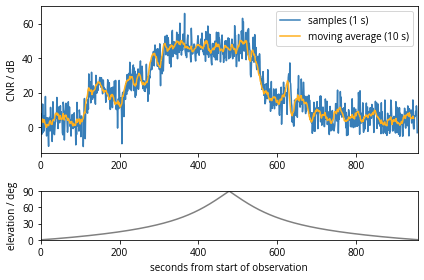

In [5]:
# Add colorblind-friendly color cycle
# See https://gist.github.com/thriveth/8560036
import cycler
CB_color_cycle = ["#377eb8", "#ffb01e", "#4daf4a",
                  "#616161", "#a65628", "#984ea3",
                  "#f781bf", "#e41a1c", "#dede00"]

import matplotlib
matplotlib.rcParams["axes.prop_cycle"] = cycler.cycler(color=CB_color_cycle)

matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams["font.family"] = "Open Sans"

# https://stackoverflow.com/a/14314054
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]})

ax1.plot(snrs, label="samples (1 s)")
ax1.plot(moving_average(snrs, 10), label="moving average (10 s)")
#ax1.set_xlabel("seconds from start of observation")
ax1.set_ylim(-15, 70)
ax1.set_xlim(0, len(snrs))
ax1.set_ylabel("CNR / dB")
ax1.legend(ncol=1)

import ephem
import datetime
import math

gsobj = ephem.Observer()
gsobj.lat = str(data["station_lat"])
gsobj.lon = str(data["station_lng"])
gsobj.elevation = data["station_alt"]
satobj = ephem.readtle(data["satellite_info"]["name"], *data["tle"])

def _elev(satobj, gsobj, ts):
    gsobj.date = datetime.datetime.utcfromtimestamp(ts)
    satobj.compute(gsobj)
    return satobj.alt / math.pi * 180.

def _delay(satobj, gsobj, ts):
    gsobj.date = datetime.datetime.utcfromtimestamp(ts)
    satobj.compute(gsobj)
    return satobj.range / 299792458

timestamps = np.arange(data["start_unix"], data["end_unix"], 1)
elevs = [_elev(satobj, gsobj, ts) for ts in timestamps]

delays = [_delay(satobj, gsobj, ts) for ts in timestamps]
print(max(delays), min(delays), np.mean(delays))

ax2.plot(elevs, color="gray", label="elevation")
ax2.set_ylabel("elevation / deg")
ax2.set_ylim(0, 90)
ax2.set_xlim(0, len(snrs))
ax2.set_xlabel("seconds from start of observation")
ax2.set_yticks((0,30,60,90))
#ax2.set_yticks(list(range(0, 91, 10)))
#ax2.legend(loc="upper right")

fig.set_size_inches(6, 4.0)
plt.tight_layout()
plt.savefig("cache.out/1132307_cnr.pdf")
plt.show()

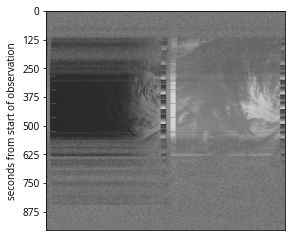

In [47]:
fig = plt.figure()
#plt.imshow(np.clip(synced, 0, 1), cmap="gray")
plt.imshow(np.clip(synced, -.25, 1.25), cmap="gray")
#plt.xlabel("index of pixel in row")
plt.ylabel("seconds from start of observation")
plt.yticks(list(range(0, len(synced), 250)), list(range(0, len(synced) // 2, 125)))
plt.ylim(len(synced), 0)
plt.xticks(())
fig.set_size_inches(6, 3.45)
plt.tight_layout()
plt.savefig("cache.out/1132307_image.pdf", dpi=300)